<img src="images/codechef_page.jpg" style="width: 800px;"/>

## Natural Language Processing and Machine Learning Experiments on CodeChef Data

> We have a dataset of programming questions and answer submissions from CodeChef, posted on kaggle.com/arjoonn/codechef-competitive-programming.  Let's try various NLP and ML models on the data.

In [295]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import wordcloud
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer

questions = pd.read_csv('codechef-competitive-programming/questions.csv')

Populating the interactive namespace from numpy and matplotlib


In [296]:
# Cleaning
import re

def clean_statement(x):
    x = re.sub('-', ' ', x)
    x = re.sub('[,|.|?|\n]|\t', '', x)
    x = re.sub('n\'t', ' not', x)
    x = re.sub('All submissions for this problem are available', '', x)
    x = re.sub('Read problems statements in Mandarin Chinese|Russian|as well', '', x)
    x = re.sub('and|Vietnamese', '', x)
    return x

# clean_statement(questions.statement[0])

questions['statement'] = [clean_statement(x) for x in questions.statement.values]
questions.head()

,QCode,Title,link,level,statement
0,SEQUENCE,Integer Sequences,/problems/SEQUENCE,medium,For a fixed integer n let x1 x2 x2n be a sequ...
1,CHEFTEAM,Chef team,/problems/CHEFTEAM,easy,Chef has N subordinates In order to complete a...
2,SEATR,Sereja and Tree,/problems/SEATR,medium,Sereja likes to hang around trees A tree is...
3,FLOW017,Second Largest,/problems/FLOW017,beginner,Three numbers A B C are the inputs Write a pr...
4,CFRTEST,Devu and friendship testing,/problems/CFRTEST,beginner,Devu has n weird friends Its his birthday ...


In [297]:
from collections import Counter
Counter(questions.level).most_common()

[('medium', 507),
 ('easy', 478),
 ('hard', 290),
 ('challenge', 100),
 ('beginner', 99)]

In [298]:
questions.level.value_counts()

medium       507
easy         478
hard         290
challenge    100
beginner      99
Name: level, dtype: int64

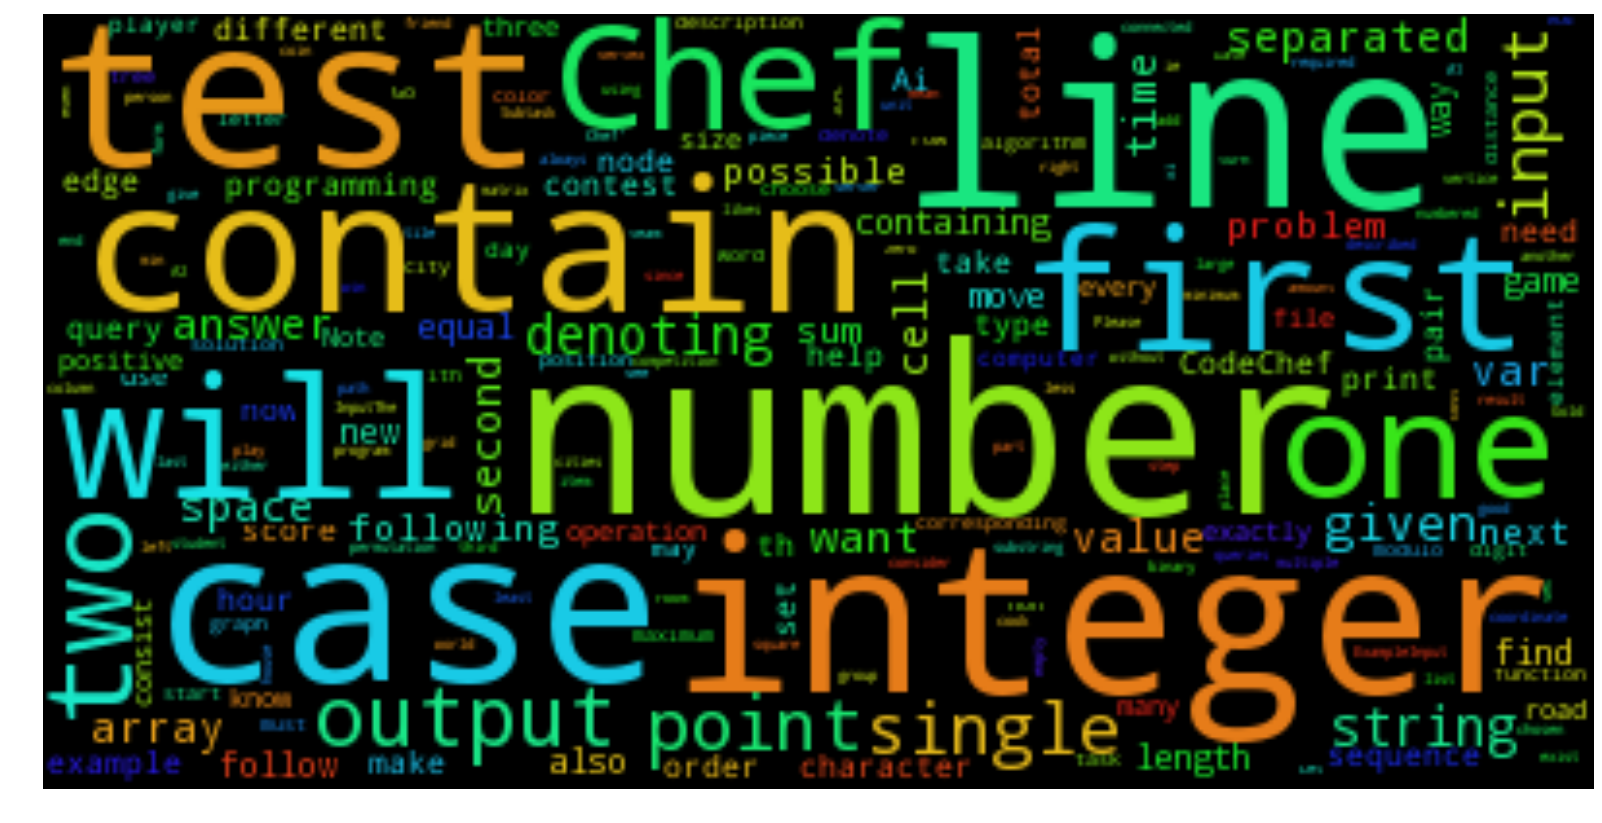

In [299]:
cloud = wordcloud.WordCloud(background_color='black', max_font_size=60, relative_scaling=.5).generate(' '.join(questions.statement))
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(cloud);

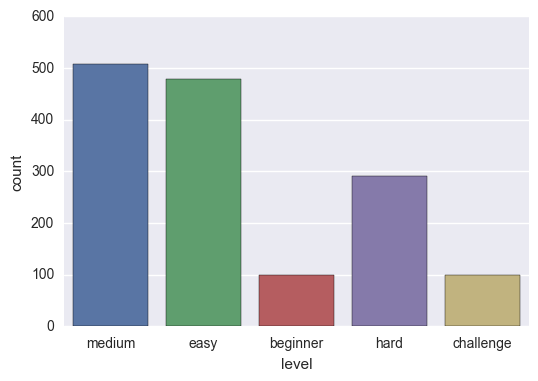

In [300]:
sns.countplot(questions.level)

In [301]:
solutions = pd.read_csv('codechef-competitive-programming/solutions.csv')
solutions.tail()

,QCode,SolutionID,timeago,UserID,Status,TimeTaken,MemTaken,Language,SolutionUrl
1008074,WSTRING,S2284937,04:31 PM 22/06/13,/users/ac_c0der,wrong answer,0.00,2.9M,C++ 4.3.2,/viewplaintext/2284937
1008075,WSTRING,S2284935,04:29 PM 22/06/13,/users/ac_c0der,time limit exceeded,-,2.9M,C++ 4.3.2,/viewplaintext/2284935
1008076,WSTRING,S2284932,04:27 PM 22/06/13,/users/jaijitendra,accepted,0.08,3.9M,C++ 4.3.2,/viewplaintext/2284932
1008077,WSTRING,S2284930,04:25 PM 22/06/13,/users/tsasaki,accepted,0.08,3.9M,C++ 4.3.2,/viewplaintext/2284930
1008078,WSTRING,S2284927,04:25 PM 22/06/13,/users/subodh545976,wrong answer,0.00,3.7M,C++ 4.3.2,/viewplaintext/2284927


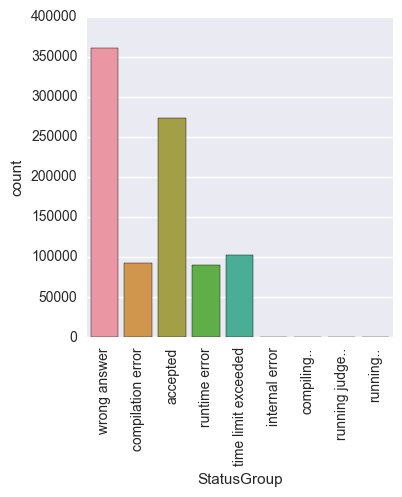

In [302]:
# Let's make better categories
solutions['StatusGroup'] = solutions.Status.str.split('(').str[0]
g = sns.factorplot("StatusGroup", data=solutions, kind="count")
g.set_xticklabels(rotation=90)

In [303]:
from collections import Counter

# Let's only see those which were either right or wrong.
sol = solutions
sol = sol.loc[(sol.StatusGroup == 'wrong answer')|(sol.StatusGroup == 'accepted')]
Counter(sol.StatusGroup)

Counter({'accepted': 273398, 'wrong answer': 360694})

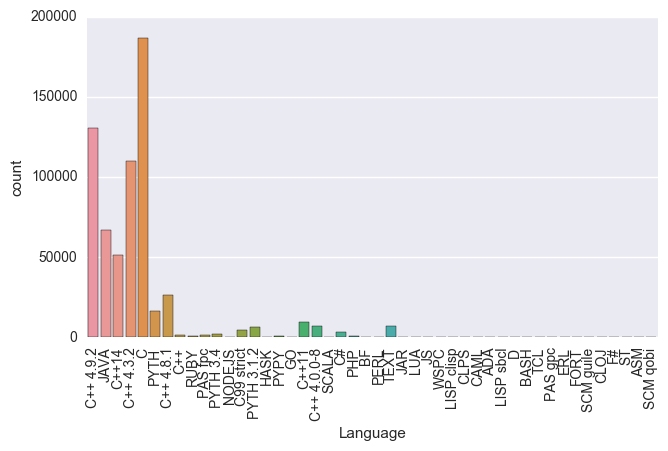

In [304]:
g = sns.factorplot("Language", data=sol, kind="count", aspect=1.7)
g.set_xticklabels(rotation=90)

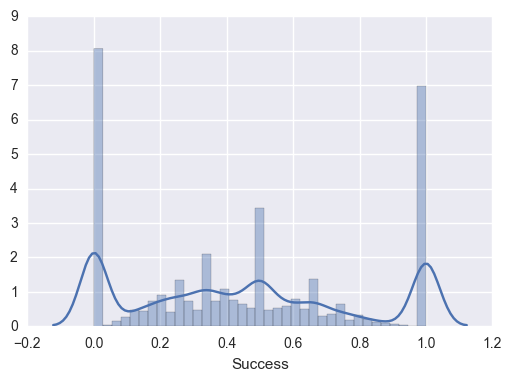

In [305]:
sol['Success'] = (sol.StatusGroup == 'accepted').astype(int)

success_ratios = sol.groupby('UserID')['Success'].mean()
success_ratios.sort()

# plt.plot(success_ratios.values, label='SuccessRatio')
# plt.plot([0, 70000], [0.5, 0.5], '-.', label='Random')
# plt.legend()

# histogram of success ratios
sol['successRatio'] = sol.UserID.map(success_ratios)
sns.distplot(success_ratios)
# most people fall into high failure, high success, or equal failure:success ratio

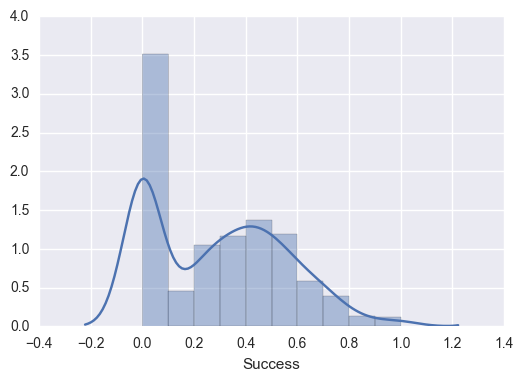

In [306]:
# create question success ratio

success_ratios = sol.groupby('QCode')['Success'].mean()
success_ratios.sort()

# plt.plot(success_ratios.values, label='SuccessRatio')
# plt.plot([0, 70000], [0.5, 0.5], '-.', label='Random')
# plt.legend()

# histogram of success ratios
sol['question_success_ratio'] = sol.QCode.map(success_ratios)
sns.distplot(success_ratios)
# most people fall into high failure, high success, or equal failure:success ratio

There's a spike of questions with low success ratio, and then the rest follows a normal-looking distribution.

In [307]:
sol.tail()

,QCode,SolutionID,timeago,UserID,Status,TimeTaken,MemTaken,Language,SolutionUrl,StatusGroup,Success,successRatio,question_success_ratio
1008072,WSTRING,S2284954,04:43 PM 22/06/13,/users/saurabh1231005,wrong answer,0.00,4M,PYTH,/viewplaintext/2284954,wrong answer,0,0.533333,0.243902
1008074,WSTRING,S2284937,04:31 PM 22/06/13,/users/ac_c0der,wrong answer,0.00,2.9M,C++ 4.3.2,/viewplaintext/2284937,wrong answer,0,0.264151,0.243902
1008076,WSTRING,S2284932,04:27 PM 22/06/13,/users/jaijitendra,accepted,0.08,3.9M,C++ 4.3.2,/viewplaintext/2284932,accepted,1,0.377778,0.243902
1008077,WSTRING,S2284930,04:25 PM 22/06/13,/users/tsasaki,accepted,0.08,3.9M,C++ 4.3.2,/viewplaintext/2284930,accepted,1,0.695652,0.243902
1008078,WSTRING,S2284927,04:25 PM 22/06/13,/users/subodh545976,wrong answer,0.00,3.7M,C++ 4.3.2,/viewplaintext/2284927,wrong answer,0,0.605263,0.243902


In [308]:
# Let's create a new table, that joins the question_success_ratio that we computed from solutions table to the questions table.
# Then we can ask questions about level vs question_success_ratio

In [309]:
success_to_level = pd.merge(questions, sol, how='inner', on='QCode', left_on=None, right_on=None,
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False)

success_to_level['statement'] = [clean_statement(x) for x in success_to_level.statement.values]

success_to_level[['level', 'statement','QCode', 'Title', 'question_success_ratio']].tail()

,level,statement,QCode,Title,question_success_ratio
634086,medium,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator,0.5
634087,medium,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator,0.5
634088,medium,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator,0.5
634089,medium,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator,0.5
634090,medium,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator,0.5


In [310]:
# drop duplicates
success_to_level = success_to_level[['level', 'question_success_ratio', 'statement','QCode', 'Title']].drop_duplicates()
success_to_level.head()

,level,question_success_ratio,statement,QCode,Title
0,easy,0.611111,In the mysterious country of Bytel everything ...,A1,Paying up
18,easy,0.428571,One evening Johnny found some funny looking be...,A2,Johnny and the Beanstalk
39,easy,0.182301,Alice Johnny are playing a simple guessing ga...,A3,The Guessing Game
604,easy,0.148974,Johnny was asked by his math teacher to comput...,A4,The Rise and Fall of Power
1725,hard,0.307692,This problem was part of the CodeChef April Ch...,A5,Packing the Boxes


In [311]:
success_to_level.tail()

,level,question_success_ratio,statement,QCode,Title
633239,hard,0.000000,Given an initially empty integer array (1 ...,XRQRS,Xor Queries
633484,medium,0.565217,Johnny has reached the final trial on the Path...,YALOP,Trial of Doom
633530,hard,0.444444,You are given the first N terms of a sequenceT...,YASEQ,Yet Another Sequence
633566,easy,0.376782,The state space of the output of this problem ...,YNOUTPUT,Forced Output
634057,medium,0.500000,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator


In [312]:
Counter(success_to_level.level).most_common()

[('easy', 250),
 ('medium', 230),
 ('hard', 143),
 ('beginner', 51),
 ('challenge', 45)]

In [313]:
# catenc = pd.factorize(success_to_level['level'])
# df['labels_enc'] = catenc[0]

# map all the level categories to integers ordered by difficulty
success_to_level['level'] = success_to_level['level'].map({'easy': 1, 'medium': 2, 'hard':3, 'beginner': 0, 'challenge':4})

# plot to see if we see any clusters
# plt.scatter(success_to_level.level, success_to_level.question_success_ratio)

In [314]:
success_to_level.tail()

,level,question_success_ratio,statement,QCode,Title
633239,3,0.000000,Given an initially empty integer array (1 ...,XRQRS,Xor Queries
633484,2,0.565217,Johnny has reached the final trial on the Path...,YALOP,Trial of Doom
633530,3,0.444444,You are given the first N terms of a sequenceT...,YASEQ,Yet Another Sequence
633566,1,0.376782,The state space of the output of this problem ...,YNOUTPUT,Forced Output
634057,2,0.500000,In the 1920's a mad scientist by the name Exor...,ZENCALC,Peaceful Calculator


In [315]:
from sklearn.cluster import KMeans
# plt.scatter(success_to_level['level'], success_to_level['question_success_ratio'])

## Let's rescale the question levels so that the x axis does not dominate the clustering.
Then apply K-means clustering.

In [316]:
import random

df = success_to_level[['level','question_success_ratio']]
# A = df.loc[start:end, idx[:, 'MSHP Bedrooms', :, :, 'C']]

# divide each value of level by 10, so that the scale is similar and narrower in range
# to that of question success ratio.

# add random noise to spread the visualization on the graph
df['level'] = df.level.apply(lambda x: x/6 + random.randint(1, 14)/100)
df.tail()

,level,question_success_ratio
633239,0.510000,0.000000
633484,0.473333,0.565217
633530,0.520000,0.444444
633566,0.176667,0.376782
634057,0.373333,0.500000


In [317]:
X = df.values
km = KMeans(n_clusters=3).fit(X)

Counter(km.labels_)

Counter({0: 348, 1: 151, 2: 220})

In [318]:
# these are the coordinates of the 3 centroids
km.cluster_centers_

array([[ 0.36092912,  0.52054216],
       [ 0.59090508,  0.07856193],
       [ 0.27074242,  0.07219422]])

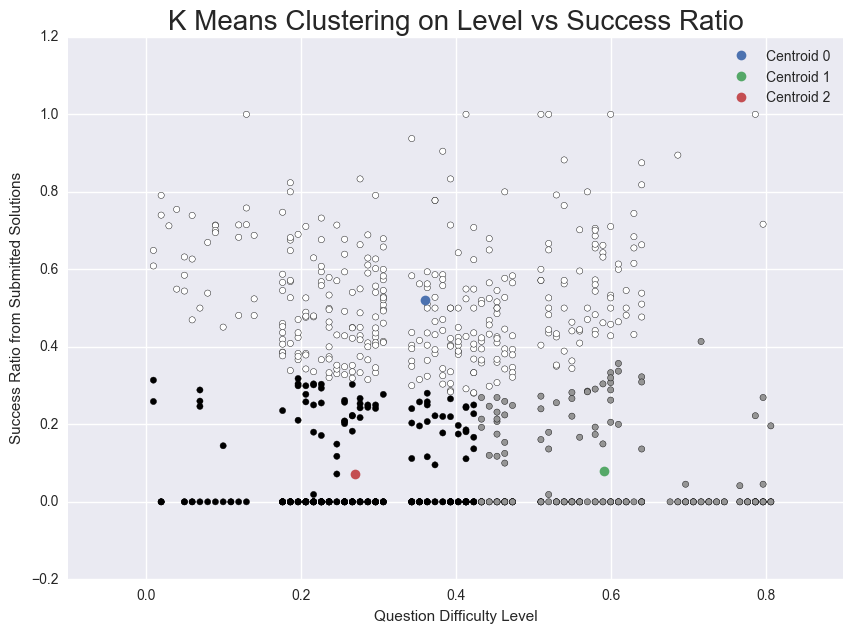

In [319]:
predictions = km.predict(X)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=predictions)
plt.plot(km.cluster_centers_[0][0], km.cluster_centers_[0][1], 'o', label='Centroid 0')
plt.plot(km.cluster_centers_[1][0], km.cluster_centers_[1][1], 'o', label='Centroid 1')
plt.plot(km.cluster_centers_[2][0], km.cluster_centers_[2][1], 'o', label='Centroid 2')

plt.title('K Means Clustering on Level vs Success Ratio', size=20)
plt.xlabel('Question Difficulty Level')
plt.ylabel('Success Ratio from Submitted Solutions')
plt.legend();

Points were clustered into 3 groups:
 - The largest cluster consists of questions that had high success ratio, irrespective of the golden labels from the dataset.
 - second largest cluster are questions labeled easy, yet have low success ratio
 - smallest cluster are questions labeled hard with low success ratio

In [320]:
# [('easy', 250),
#  ('medium', 230),
#  ('hard', 143),
#  ('beginner', 51),
#  ('challenge', 45)]

# Let's choose k=3 to cluster into easy, medium, hard.  With k-means, we can perhaps see if the success ratio
# for certain questions don't reflect their golden labels.  In other words, we'll be able to see easy questions that
# have 

# df = success_to_level[['question_success_ratio']]
X = success_to_level[['question_success_ratio']].values
km = KMeans(n_clusters=3).fit(X)

Counter(km.labels_)

Counter({0: 160, 1: 281, 2: 278})

In [321]:
# these are the coordinates of the 3 centroids
km.cluster_centers_

array([[ 0.65105744],
       [ 0.0161496 ],
       [ 0.36038497]])

In [322]:
Counter(km.predict(X))

Counter({0: 160, 1: 281, 2: 278})

In [323]:
# we input only the question_success_ratio values into k-means.

df['predictions'] = km.predict(X)
df.tail()

,level,question_success_ratio,predictions
633239,0.510000,0.000000,1
633484,0.473333,0.565217,0
633530,0.520000,0.444444,2
633566,0.176667,0.376782,2
634057,0.373333,0.500000,2


Centroids were chosen off question_success_ratio, not the (level, question_success_ratio) coordinates.

## Plot the silhouette scores to determine the optimal value of k.

Perhaps it could help decide into how many difficulty levels to cluster the question statements.

In [324]:
from sklearn.metrics import silhouette_score

def plot_silhouette(data, clusters):
    '''
    Input:
        data - (DataFrame) Data to cluster on
        clusters - (list) List containing the number of clusters to check for
    Output:
        Plot showing the silhouette score for different numbers of centroids
    '''  
    df = data
    X = data.values
    
    vertical_axis = []
    
    for k in clusters:
        within_cluster_sum_of_squares = []
        km = KMeans(n_clusters=k).fit(X)
        centroids = km.cluster_centers_
        
#         for i in range(len(centroids)):
#             within_cluster_sum_of_squares.append(silhouette_score(df, km.labels_))
        
        vertical_axis.append(silhouette_score(df, km.labels_))

    plt.plot(clusters, vertical_axis)

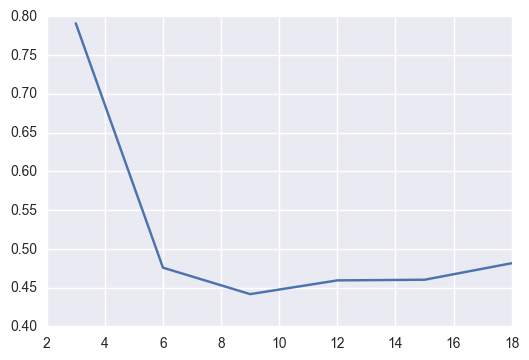

In [325]:
num_clusters = list(range(3, 20, 3))

plot_silhouette(df, num_clusters)

Based off the graph, let's choose k to be 6.  Another thing we can do is plot the original dataset at an alpha = 0.1, to help us identify possible clusters.

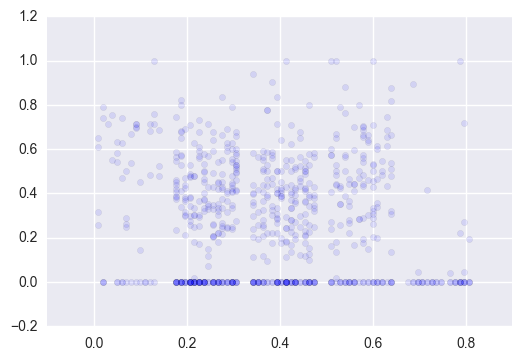

In [326]:
scatter(df['level'], df['question_success_ratio'], alpha=.1)

In [327]:
X = df.values
km = KMeans(n_clusters=6).fit(X)

Counter(km.labels_)

Counter({0: 104, 1: 144, 2: 85, 3: 134, 4: 75, 5: 177})

In [328]:
# these are the coordinates of the 6 centroids
km.cluster_centers_

array([[  6.15384615e-01,   1.85129158e-02,   1.00000000e+00],
       [  4.89189815e-01,   3.61983426e-01,   2.00000000e+00],
       [  2.08039216e-01,   6.33111864e-01,   4.44089210e-16],
       [  2.48258706e-01,   3.58667224e-01,   2.00000000e+00],
       [  5.24622222e-01,   6.71395761e-01,   4.44089210e-16],
       [  2.80527307e-01,   1.47609893e-02,   1.00000000e+00]])

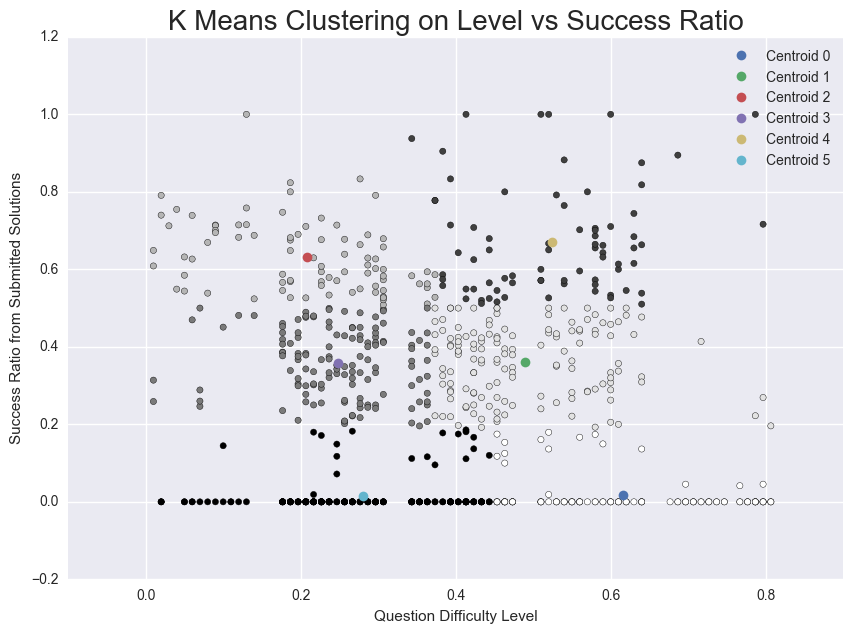

In [329]:
predictions = km.predict(X)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=predictions)

for i in range(6):
    plt.plot(km.cluster_centers_[i][0], km.cluster_centers_[i][1], 'o', label='Centroid '+str(i))

    
plt.title('K Means Clustering on Level vs Success Ratio', size=20)
plt.xlabel('Question Difficulty Level')
plt.ylabel('Success Ratio from Submitted Solutions')
plt.legend();

## Load in the datasets containing code snippets of submitted solutions:

In [330]:
from sklearn.decomposition import PCA, kernel_pca
from sklearn.manifold import TSNE

base = 'codechef-competitive-programming/program_codes/code/'
# # READ Stuff

sols = pd.read_csv('codechef-competitive-programming/solutions.csv', usecols=['QCode',
                                                      'SolutionID',
                                                      'Status', 'Language']).dropna()
first, second, third = [pd.read_csv(base+i+'.csv') for i in 'first,second,third'.split(',')]
# Merge stuff
code = pd.concat([first, second, third])
df = sols.merge(code, how='left', on='SolutionID')
del(sols);del(code);del(first);del(second);del(third)

df = df.dropna()

# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917340 entries, 0 to 920009
Data columns (total 5 columns):
QCode         917340 non-null object
SolutionID    917340 non-null object
Status        917340 non-null object
Language      917340 non-null object
Solutions     917340 non-null object
dtypes: object(5)
memory usage: 42.0+ MB


In [331]:
Counter(df.Language).most_common()[:10]

[('C', 270297),
 ('C++ 4.9.2', 168202),
 ('C++ 4.3.2', 153668),
 ('JAVA', 116274),
 ('C++14', 65946),
 ('C++ 4.8.1', 37976),
 ('PYTH', 26418),
 ('C++11', 13115),
 ('C++ 4.0.0-8', 11273),
 ('PYTH 3.1.2', 10418)]

## Let's classify submissions as either Python or C++

In [332]:
# Let's consider solutions in either PYTH or C++11.

# We only use what we need. So we drop a few columns
df = df[['QCode', 'SolutionID','Solutions', 'Status', 'Language']]
df.Language = df.Language.str.split(' ').str[0]
df = df[(df.Language == 'C++11') | (df.Language == 'PYTH')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52944 entries, 23 to 920003
Data columns (total 5 columns):
QCode         52944 non-null object
SolutionID    52944 non-null object
Solutions     52944 non-null object
Status        52944 non-null object
Language      52944 non-null object
dtypes: object(5)
memory usage: 2.4+ MB


In [333]:
Counter(df.Language).most_common()

[('PYTH', 39829), ('C++11', 13115)]

In [334]:
df.tail()

,QCode,SolutionID,Solutions,Status,Language
919916,WSTRING,S2844409,\n #include<iostream>\n #include<string....,wrong answer,C++11
919917,WSTRING,S2844377,\n #include<iostream>\n #include<string....,wrong answer,C++11
919994,WSTRING,S2285350,\n def fun(s):\n max = 0\n fo...,runtime error(NZEC),PYTH
920001,WSTRING,S2284959,\n def fun(s):\n max = 0\n fo...,wrong answer,PYTH
920003,WSTRING,S2284954,\n def fun(s):\n max = 0\n fo...,wrong answer,PYTH


## two-class classification dataset

Let's train a classification model on the solutions dataset, where the programming language is either C++11 or Python!

Given a sample solution, we want to assign the label "C++11" or "Python" based on the text content of the solution.  This is a standard binary classification task.


reference:  Introduction to Machine Learning with Python: A Guide for Data Scientists 1st Edition
by Andreas C. Müller, Sarah Guido

In [348]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.Solutions, df.Language, test_size=0.4, random_state=0)
print("type of text_train: {}".format(type(X_train)))
print("length of X_train: {}".format(len(X_train)))
list(X_train)[15]  # C++

type of text_train: <class 'pandas.core.series.Series'>
length of X_train: 31766


'\n    \n           #include<bits/stdc++.h>\n    \n           using namespace std;\n    \n          bool b[100001];\n          int cnt=0;\n    \n    \n           void dfs(int v,vector<int>myvector[]){\n    \n              b[v]=true;\n              cnt++;\n              for(vector<int>::iterator it=myvector[v].begin();it!=myvector[v].end();it++){\n                  if(b[*it]==false){\n                    dfs(*it,myvector);\n                  }\n              }\n           }\n    \n    \n           int main(){\n             int T;\n             scanf("%d",&T);\n             while(T--){\n               for(int i=0;i<=100001;i++){\n                b[i]=false;\n               }\n               int N,M;\n               scanf("%d%d",&N,&M);\n               vector<int>myvector[N+1];\n    \n    \n               for(int k=1;k<=M;k++){\n                int i,j;\n    \n                scanf("%d%d",&i,&j);\n                myvector[i].push_back(j);\n                myvector[j].push_back(i);\n      

In [336]:
list(X_train)[17]  # Python

"\n    def isqrt(x):\n        n = int(x)\n        if n == 0:\n            return 0\n        a, b = divmod(n.bit_length(), 2)\n        x = 2**(a+b)\n        while True:\n            y = (x + n//x)//2\n            if y >= x:\n                return x\n            x = y\n    def isfib(n):\n        sq = 5*(n*n)+4\n        if isqrt(sq)**2-sq==0:\n            return True\n        else:\n            sq = sq-8\n            if isqrt(sq)**2-sq==0:\n                return True\n            else:\n                return False\n    y = int(input())\n    while y :\n        t = int(input())\n        if isfib(t) :\n            print('YES')\n        else :\n            print('NO')\n        y-=1\n\n"

You can see that text_train is a pandas.core.series.Series of length 31,881, where each entry is a string containing a review. We printed 2 example code samples.

In [337]:
print("Number of documents in test data: {}".format(len(X_test)))

Number of documents in test data: 21178


We'll do a bag of words processing with tokenization, where we split each document into words; vocabulary building, where we collect a vocabulary of all words that appear in any of the documents and number them; and encoding, where we count how often each of the words in the vocabulary appear in this document.

Training a logistic regression model for
document classification

In [349]:
vect = CountVectorizer().fit(X_train)
X_train = vect.transform(X_train)

In [350]:
# apply CountVectorizer for X_test
vect = CountVectorizer().fit(X_test)
X_test = vect.transform(X_test)

In [339]:
print("X_train:\n{}".format(repr(X_train)))

X_train:
<31766x38634 sparse matrix of type '<class 'numpy.int64'>'
	with 859880 stored elements in Compressed Sparse Row format>


The shape of X_train, which represents the bag of words representation of the training data is 31772x38672, indicating that the vocabulary contains 38,672 entries.  The data is stored in a SciPy sparse matrix.

In [340]:
# We can access the vocabulary to return a list 
# where each entry corresponds to one feature.


feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 38634
First 20 features:
['00', '000', '00000', '000000', '0000000', '0000000000', '000000000000001', '00000000000001', '0000000000001', '0000000001', '00000001', '0000001', '000001', '000005', '00001', '0001', '001', '002', '007', '01']
Features 20010 to 20030:
['defacingindex', 'defacingoptions', 'defacingscore', 'defalut', 'default', 'default_cost', 'default_limit', 'default_min', 'default_random_engine', 'default_rate', 'default_timer', 'default_value', 'defaultcost', 'defaultdict', 'defenselessness', 'define', 'defined', 'defined_year', 'defineinfor', 'defineoutfor']
Every 2000th feature:
['00', '1484', '212207101440105399533740733471l', '3010', '400778865046997419409593818195095036058794082069603285936485366789883567055193l', '536870912', '68207', '83243', 'ang2', 'chef_str', 'defaced_max_length', 'findflow', 'in1v3', 'level1', 'monster', 'od', 'provided', 'ser_score', 'temparr', 'whole']


As expected, there are many numbers and most of them don't have any immediate semantic meaning.

Let's build a classifier.  Since we have high-dimensional, sparse data, a linear model like LogisticRegression works best.

# LogisticRegression using cross-validation

In [344]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10)
print("Mean cross-validation accuracy: {}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.9959705463307194


We expect scores to be high because the appearance of language-specific keywords is highly correlated to the programming langauge.

Let's perform grid search and tune via cross-valudation our regularization parameter C.  Higher C results in higher variance.

In [342]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.9964112573191463
Best parameters:  {'C': 0.1}


On training data, our cross validation score is .996 using C=0.1.

In [351]:
scores = cross_val_score(LogisticRegression(), X_test, y_test, cv=10)
print("Test Data:")
print("Mean cross-validation accuracy: {}".format(np.mean(scores)))

Test Data:
Mean cross-validation accuracy: 0.9950892610105836


# Topic Modeling

## Topic Modeling with Non-Negative Matrix factorization (NMF)

NMF with scikit-learn

Can we cluster question statements into discrete topics?  Let's apply topic modeling using NMF and LDA (Latent Dirichlet allocation), and see if we can discover hidden semantic structures.

2) Use the [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) from scikit-learn to turn the content of the question statements into the document-term matrix $\textbf{A}$ 

(I call it "vectorized")

In [52]:
import sklearn
assert sklearn.__version__ == '0.18' # Make sure we are in the modern age
from sklearn.feature_extraction.text import CountVectorizer

# Here are some good defaults
max_features=1000
max_df=0.95,  
min_df=2,
max_features=1000,
stop_words='english'

from nltk.corpus import stopwords
stop = stopwords.words('english')

# document-term matrix A
vectorized = CountVectorizer(max_features=1000, max_df=0.95, min_df=2, stop_words='english')

a = vectorized.fit_transform(questions.statement)
a.shape

# so n is 1474, and m is 1000

(1474, 1000)

Apply NMF with SVD-based initialization to the document-term matrix $\text{A}$ generate topics.

In [53]:
from sklearn.decomposition import NMF
model = NMF(init="nndsvd",
            n_components=4,
            max_iter=200)

Get the factors $\text{W}$ and $\text{H}$ from the resulting model.

In [54]:
W = model.fit_transform(a)
H = model.components_

print("W:", W.shape)
print("H:", H.shape)

W: (1474, 4)
H: (4, 1000)


Get the list of all terms whose indices correspond to the columns of the document-term matrix.

In [55]:
vectorizer = vectorized

terms = [""] * len(vectorizer.vocabulary_)
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term
    
# Have a look that some of the terms
terms[-5:]
# terms

['y2', 'year', 'yes', 'yi', 'zero']

top 10 ranked terms for each topic, by sorting the values in the rows of the $\text{H}$ factor 

In [56]:
import numpy as np

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))

Topic 0: test, number, line, case, contains, integer, integers, output, cases, single
Topic 1: var, codechef, programming, hour, new, date, computer, contest, min, sec
Topic 2: tile, letter, tiles, word, points, array, letters, cell, blank, score
Topic 3: chef, server, number, time, password, computer, chefs, servers, line, order


In [57]:
model = NMF(init="nndsvd",
            n_components=15,
            max_iter=200)

W = model.fit_transform(a)
H = model.components_

vectorizer = vectorized

terms = [""] * len(vectorizer.vocabulary_)
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))

Topic 0: line, integers, contains, integer, array, denoting, space, separated, ai, query
Topic 1: var, codechef, programming, hour, new, date, contest, min, sec, contests
Topic 2: tile, letter, tiles, word, points, array, letters, blank, play, words
Topic 3: chef, chefs, day, time, wants, line, dish, single, contains, dishes
Topic 4: computer, time, computers, ciel, program, piece, expected, center, connect, password
Topic 5: number, numbers, line, single, contains, lines, soldiers, integer, odd, input
Topic 6: test, case, cases, line, integer, output, contains, single, sum, containing
Topic 7: string, strings, contains, length, characters, substring, line, character, case, given
Topic 8: server, password, servers, chef, data, tries, number, prime, order, numbers
Topic 9: node, nodes, graph, edge, edges, tree, cost, path, vertex, score
Topic 10: cell, cells, snake, grid, judge, color, number, new, row, x1
Topic 11: city, cities, road, roads, line, capital, path, lines, contains, juncti

Repeat with the same modeling with [`tf-idf`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). 

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

# document-term matrix A
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.95, min_df=2, stop_words='english')

vectorized = tfidf_vectorizer

a = vectorized.fit_transform(questions.statement)

model = NMF(init="nndsvd",
            n_components=15,
            max_iter=200)

W = model.fit_transform(a)
H = model.components_


vectorizer = vectorized

terms = [""] * len(vectorizer.vocabulary_)
for term in vectorizer.vocabulary_.keys():
    terms[vectorizer.vocabulary_[term]] = term

for topic_index in range(H.shape[0]):  # H.shape[0] is k
    top_indices = np.argsort(H[topic_index,:])[::-1][0:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))

Topic 0: test, case, number, line, cases, contains, integer, output, positive, single
Topic 1: var, programming, codechef, hour, date, new, icpc, acm, contests, sec
Topic 2: string, strings, substring, length, characters, character, substrings, letters, palindrome, latin
Topic 3: cell, cells, grid, row, column, color, rows, columns, board, right
Topic 4: node, nodes, tree, path, trees, edge, root, distance, associated, cost
Topic 5: city, cities, road, roads, cost, country, capital, path, trip, chefl
Topic 6: array, elements, ai, operation, subarray, operations, sereja, arrays, integers, element
Topic 7: chef, chefs, dishes, time, wants, dish, day, make, single, number
Topic 8: game, player, players, play, turn, alice, wins, win, bob, stones
Topic 9: graph, vertices, edges, vertex, edge, connected, directed, path, weight, pair
Topic 10: query, queries, type, answer, contains, types, number, line, integers, set
Topic 11: digits, lucky, numbers, digit, number, decimal, ciel, positive, re

These clusters help us understand how questions fall into categories.  For instance, questions about trees (Topic 4) tend to have an intuitive set of associated words.

## How many questions fall into each of the 15 topics?

In [59]:
# this counter counts the number of question staments primarily beloning to each of the above topics.

Counter([np.argmax(i) for i in W]).most_common()

[(13, 193),
 (7, 172),
 (0, 169),
 (2, 130),
 (14, 119),
 (3, 90),
 (8, 88),
 (11, 84),
 (6, 79),
 (10, 77),
 (12, 73),
 (5, 57),
 (4, 49),
 (9, 48),
 (1, 46)]

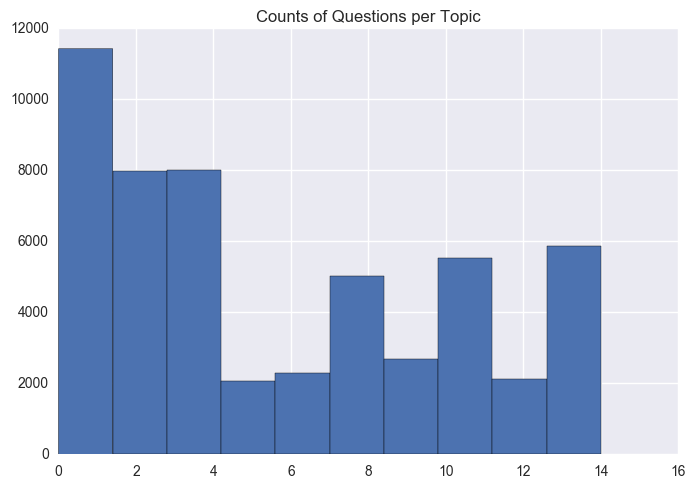

In [260]:
hist([np.argmax(i) for i in W])
plt.title("Counts of Questions per Topic")

---
Scikit-learn's LDA
------

Use [Scikit-learn's LDA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) to find topics.

Let's apply Latent Dirichlet allocation (LDA) to the corpus of Codechef question statements to discover latent topics.

In [61]:
from sklearn.decomposition.online_lda import LatentDirichletAllocation

# document-term matrix A
tfidf_vectorizer = TfidfVectorizer(max_features=1000, max_df=0.95, min_df=2, stop_words='english')
vectorized = tfidf_vectorizer
vectorized = vectorized.fit_transform(questions.statement)

lda = LatentDirichletAllocation(n_topics=4,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(vectorized), lda.components_.shape

(LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
              evaluate_every=-1, learning_decay=0.7,
              learning_method='online', learning_offset=50.0,
              max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
              n_jobs=1, n_topics=4, perp_tol=0.1, random_state=42,
              topic_word_prior=None, total_samples=1000000.0, verbose=0),
 (4, 1000))

In [62]:
def print_top_words(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx, end = "")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

print("Topics in LDA model:")

# print(type(tfidf_vectorizer))
# print(type(vectorized))

vectorizer = tfidf_vectorizer

tf_feature_names = vectorizer.get_feature_names()  # TfidfVectorizer
print_top_words(lda, tf_feature_names)

Topics in LDA model:
Topic #0:var programming codechef hour date icpc new acm sec computer contests contest competition gold min
Topic #1:password servers tiles snake server tile cell exit node cells test score tree tries x1
Topic #2:test number line case chef contains integer integers string points cases single output denoting numbers
Topic #3:sequence string abc vertices sereja number matrix line edges tree graph integer subsequence test node



In [63]:
lda = LatentDirichletAllocation(n_topics=15,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(vectorized)


print("Topics in LDA model:")

# print(type(tfidf_vectorizer))
# print(type(vectorized))

vectorizer = tfidf_vectorizer

tf_feature_names = vectorizer.get_feature_names()  # TfidfVectorizer
print_top_words(lda, tf_feature_names)

Topics in LDA model:
Topic #0:room johnny digits rooms odd case word guest person chef line party test appear example
Topic #1:game test score cells query string alice digits queries length points number line contains integer
Topic #2:coins test player graph line game number case sequence items chef players time contains integers
Topic #3:squares number triangle line test x1 case x2 base contains ways numbers chef coordinates integer
Topic #4:var servers programming hour codechef test min number color password computer lines ith line 26
Topic #5:test number line case chef contains integer integers string points cases single output denoting numbers
Topic #6:friend test number network positive friends cases string having country bytel character wo integer height
Topic #7:string number array test line points strings sum contains notes case query given tree integer
Topic #8:var programming codechef hour date icpc acm new contests sec contest computer competition min initiative
Topic #9:xor

I think that the results of the LDA model's generated topics make less sense intuitively.  If we think of topics as group of words that commonly appear together in the same stament, the NMF model generates results closer to what we'd expect.

Within a document, a word can belong only to a single topic.  So inside a docment, if "bank" gets labeled in the "finance" topic, all occurances of "bank" in the document get assigned the "finance" topic.

## Experiment!  Let's create topic models on code snippets

Could we guess what what question the code is answering?  Since code has more structure than English and we have a bag of words assumptions, results would probably be nonsensical, but let's experiment.  We'll use NMF with tfidf, since I think it's the most impressive.

In [64]:
vectorizer = TfidfVectorizer(max_df=0.95,  
                            min_df=2,
                            max_features=1000,
                            stop_words='english')

vectorized = vectorizer.fit_transform(df['Solutions'].values.astype('U'))  ## Even astype(str) would work

In [65]:
model = NMF(init="nndsvd",
            n_components=15,
            max_iter=200)
W = model.fit_transform(vectorized)
H = model.components_

for topic_index in range(H.shape[0]):
    top_indices = np.argsort(H[topic_index,:])[::-1][0:10]
    term_ranking = [terms[i] for i in top_indices]
    print("Topic {}: {}".format(topic_index, ", ".join(term_ranking)))

Topic 0: google_conversion_id, got, present, recognition, size, light, y1, similarly, 01, 05
Topic 1: got, called, gives, colored, spaces, determine, having, units, moving, level
Topic 2: rectangles, got, present, size, light, recognition, www, y1, st, _gaq
Topic 3: submit, special, removed, girl, light, got, replace, present, www, similarly
Topic 4: codechef, 23, recognition, inside, base, associated, st, constraints, ak, 02
Topic 5: aim, list, got, aj, match, scores, element, cell, read, ajax
Topic 6: able, ri, constraints, www, inside, fibonacci, max, st, middle, base
Topic 7: ingredients, password, paths, list, wo, _gaq, coordinates, winning, longest, localtime
Topic 8: occurs, 01, containing, task, dist, operations, launched, ri, constraints, time
Topic 9: described, present, inside, ri, constraints, y1, element, 50, 45, contests
Topic 10: straight, 01, y1, light, johnny, size, 19, max, given, 02
Topic 11: lacs, constraints1, gives, scores, just, previous, got, ri, ki, middle
Topi

It is not obvious how these topic models could help organize the collection of solutions.

## Text Classification for level of difficulty

We will be using Naïve Bayes as the classifier. Our classifier will use word counts as features and make a classification decision on the level of difficulty.

In [288]:
from sklearn.model_selection import train_test_split

# Create train/test split with labels
train_data, test_data, train_target, test_target = train_test_split(questions.statement,
                                                                    questions.level,
                                                                    test_size=.2,
                                                                    random_state=10)


# Transform train data from a list of strings into a matrix of frequency counts
vectorizer_count = CountVectorizer()

# fit the instance to the training data
vectorized_count_train_data = vectorizer_count.fit_transform(train_data)

print("There are {:,} words in the vocabulary.".format(len(vectorizer_count.vocabulary_)))
print("'{}' appears {:,} times.".format('tree', vectorizer_count.vocabulary_['tree']))

from sklearn.naive_bayes import MultinomialNB

# Create an instance of the Naive Bayes class 
clf = MultinomialNB()
# Call fit method
clf.fit(vectorized_count_train_data, train_target)

# Score the test data with your NB model
accuracy = clf.score(vectorizer_count.transform(test_data), test_target)

print("The accuracy on the test data is {:.2%}".format(accuracy))

There are 20,267 words in the vocabulary.
'tree' appers 18,822 times.
The accuracy on the test data is 45.76%


Let's try it again with tf-idf

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Transform train data from a list of strings into a matrix of frequency counts
vectorizer_tf_idf = TfidfVectorizer()

Now fit a new NB classifer instance with the tf-idf vectorized data.

(TfidfTransformer:
    Apply Term Frequency Inverse Document Frequency normalization to a sparse matrix of occurrence counts.)

In [68]:
vectorized_train_data = vectorizer_tf_idf.fit_transform(train_data)

# Create an instance of the Naive Bayes class 
clf_tf_idf = MultinomialNB()
# Call fit method
clf_tf_idf.fit(vectorized_train_data, train_target)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [69]:
print("The accuracy on the test data is {:.2%}".format(clf.score(vectorizer_tf_idf.transform(test_data), test_target)))

The accuracy on the test data is 46.10%


Let's calculate the precision on the test data.

In [70]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# [('medium', 507),
#  ('easy', 478),
#  ('hard', 290),
#  ('challenge', 100),
#  ('beginner', 99)]

cm_train = confusion_matrix(train_target,
                            clf_tf_idf.predict(vectorizer_tf_idf.transform(train_data)), labels = ['easy', 'medium'])
cm_train

array([[337,  47],
       [  5, 388]])

Let's consider the confusion matrix for the 2 most common labels, easy and medium.  

In [71]:
cm_test = confusion_matrix(test_target,
                           clf_tf_idf.predict(vectorizer_tf_idf.transform(test_data)),
                           labels = ['easy', 'medium'])
cm_test

array([[39, 55],
       [22, 92]])

In [72]:
# Thus in binary classification, the count of true negatives is
# :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
# :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.

# true negatives is quadrant II, true positibes is quadrant I
print('true negatives: ', cm_test[0][0])
print('false negatives: ', cm_test[1][0])
print('true positives: ', cm_test[1][1])
print('false positives: ', cm_test[0][1])

true negatives:  39
false negatives:  22
true positives:  92
false positives:  55


In [73]:
import matplotlib.pyplot as plt
import numpy as np

def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)
    
    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()
    
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)

    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))
    
    plt.tight_layout()
    plt.show()

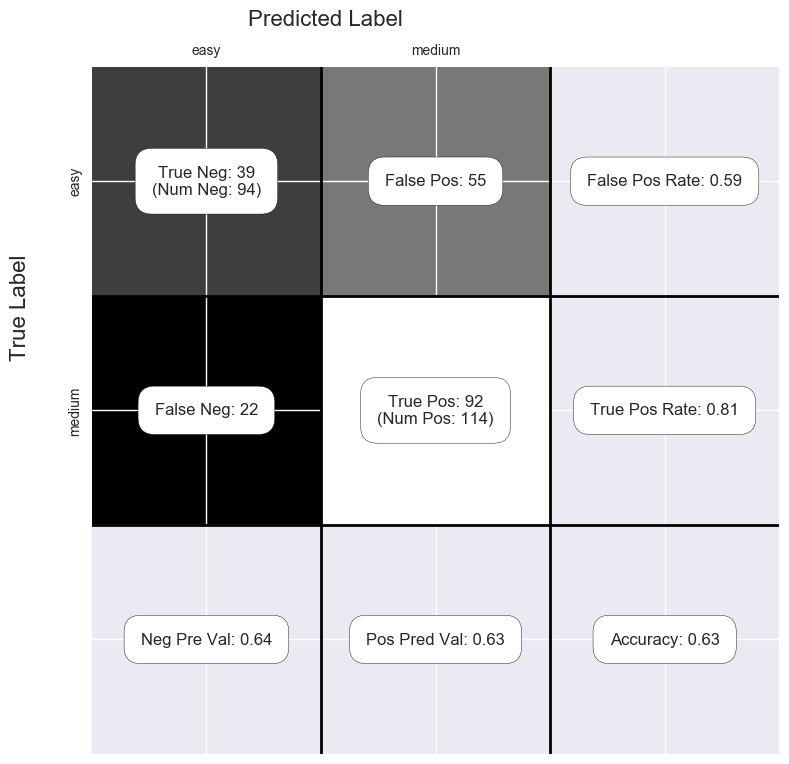

In [74]:
show_confusion_matrix(cm_test,
                     class_labels=["easy", "medium"])

Now use 10-fold cross-validation training and testing on this data. What is the average accuracy? 

In [75]:
# this considers all the classifiers

from sklearn.model_selection import KFold

# Conduct k-fold cross validation
k_fold = KFold(n_splits=10,
               random_state=42)

accuracy_by_fold = []

data = questions.statement
target = questions.level

for train_index, test_index in k_fold.split(data):
    data_train, data_test = np.array(data)[train_index], np.array(data)[test_index]
    target_train, target_test = np.array(target)[train_index], np.array(target)[test_index]
    vectorized_train_data = vectorizer_count.fit_transform(data_train)
    clf.fit(vectorized_train_data, target_train)
    accuracy = clf.score(vectorizer_count.transform(data_test), target_test)
    accuracy_by_fold.append(accuracy)

accuracy_by_fold

[0.42567567567567566,
 0.3783783783783784,
 0.41216216216216217,
 0.45270270270270269,
 0.35374149659863946,
 0.39455782312925169,
 0.38775510204081631,
 0.39455782312925169,
 0.45578231292517007,
 0.39455782312925169]

If the bag of words of the question statements were strong indicators of difficulty level, one way to improve the accuracy is through boosting techniques - try retraining the model with the false negatives having greater weight.

In [76]:
from sklearn.cross_validation import cross_val_score

cm_train

array([[337,  47],
       [  5, 388]])

In [77]:
from statistics import mean
print("The average accuracy on the test data is {:.2%}".format(mean(accuracy_by_fold)))

The average accuracy on the test data is 40.50%


The 10-fold cross-validation training and testing gives us an averaged accuracy of the model.

In [78]:
X_test = vectorizer_count.transform(test_data)
y_predict = clf.predict(X_test)

Let's calculate the F1 score:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/7d63c1f5c659f95b5dfe5893213cc8ea7f8bea0a" style="width: 400px;"/>

In [79]:
tn, fp, fn, tp = cm_train.ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = (2*precision*recall) / (precision+recall)
print("train data f1_score: ", f1_score)  # on train data

train data f1_score:  0.937198067633


In [80]:
accuracy_train = (tp+tn)/(tp+tn+tp+fn)

# train data

In [81]:
tn, fp, fn, tp = cm_test.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = (2*precision*recall) / (precision+recall)
print("test data f1_score", f1_score)  # on test data

test data f1_score 0.704980842912


In [82]:
accuracy = (tp+tn)/(tp+tn+tp+fn)
print("train data accuracy: ", accuracy_train)
print("test data accuracy: ", accuracy)  # test data

train data accuracy:  0.648479427549
test data accuracy:  0.534693877551


Since the base-line proportion of easy to medium was about 50%, the model performed at baseline, which is really bad.  Also, the accuracy of the model on the training set was higher than the accuracy of the model on the test data, so the model was overfit.  

## Sentiment Analysis

----

Let's experiment with another sentiment tool: [TextBlob](https://textblob.readthedocs.org/en/dev/quickstart.html#sentiment-analysis)

It comes pretrained...

Do coding challenge question statements generally express positive or negative sentiment?  

In [83]:
from textblob import TextBlob
# Fit TextBlob to the question statements.
testimonial = TextBlob(" ".join(questions.statement))

testimonial.sentiment, testimonial.sentiment.polarity

(Sentiment(polarity=0.0662212856306699, subjectivity=0.4231108107510163),
 0.0662212856306699)

In [359]:
# as a point of reference, let's see what the sentiment and subjectivity is on a toy string

testimonial = TextBlob("have a great day")

testimonial.sentiment, testimonial.sentiment.polarity

(Sentiment(polarity=0.8, subjectivity=0.75), 0.8)

So, the sentiment is close to 0, and we can see that the question statements are generally neutral in sentiment, as expected.

## Train Various Classifiers to predict success

As an exercise, we could try to predict Success based on TimeTaken, MemTaken, and question_success_ratio

In [264]:
# for less time spent training, let's consider only solutions written in Python.
sol = sol[(sol.Language == 'PYTH')]

# prepare the MemTaken column
sol["memory_space"] = sol.MemTaken.apply(lambda x: x.replace("M", ""))
# sol.tail()
# sol["MemTaken"] = [float(sol["MemTaken"][i].replace("M", "")) for i in range(len(sol.MemTaken))]

sol.tail()

,QCode,SolutionID,timeago,UserID,Status,TimeTaken,MemTaken,Language,SolutionUrl,StatusGroup,Success,successRatio,question_success_ratio,memory_space
1007867,YNOUTPUT,S1684755,05:28 PM 06/01/13,/users/durgesh219,accepted,0.02,7.6M,PYTH,/viewplaintext/1684755,accepted,1,0.425000,0.376782,7.6
1007944,YNOUTPUT,S1273151,01:09 AM 20/08/12,/users/torimal,wrong answer,0.10,3.7M,PYTH,/viewplaintext/1273151,wrong answer,0,0.250000,0.376782,3.7
1007948,YNOUTPUT,S1273139,01:08 AM 20/08/12,/users/torimal,wrong answer,0.13,3.7M,PYTH,/viewplaintext/1273139,wrong answer,0,0.250000,0.376782,3.7
1008070,WSTRING,S2284959,04:48 PM 22/06/13,/users/saurabh1231005,wrong answer,0.00,4M,PYTH,/viewplaintext/2284959,wrong answer,0,0.533333,0.243902,4
1008072,WSTRING,S2284954,04:43 PM 22/06/13,/users/saurabh1231005,wrong answer,0.00,4M,PYTH,/viewplaintext/2284954,wrong answer,0,0.533333,0.243902,4


# Kernelized support vector machines
(often just referred to as SVMs) are an extension that allows for more complex models that are not defined simply by hyperplanes in the input space.


In [269]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
# kernel SVM on the dataset by using the MinMaxScaler for preprocessing

# there aren't enough features to try SVM like this.
# Let's make predictions on the question difficulty based off success_ratios from the submitted solutions.
# X = success_to_level.question_success_ratio
# y = success_to_level.level

# use these features instead
# We could try to predict Success based on TimeTaken, MemTaken, and question_success_ratio
X = sol[['TimeTaken', 'memory_space', 'question_success_ratio']]
y = sol['Success']

# load and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y)

# compute minimum and maximum on the training data
scaler = MinMaxScaler().fit(X_train)

# rescale the training data
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# # learn an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)

print("SVM")
print("Train score: {:.2f}".format(svm.score(X_train_scaled, y_train)))
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

SVM
Train score: 0.75
Test score: 0.75


>Keep in mind that we're using each question's success ratio to predict success.  The only other features we include are TimeTaken and MemorySpace.

>Hence, we're using past/aggregate performance and adding in a few extra variables to predict success.

In [275]:
# let's check the counts of success labels to determine baseline and reason about class imbalance:

Counter(sol.Success)

Counter({0: 8159, 1: 8304})

>Since the number of no success and success are about even, we don't need to correct class imbalance issues.  It also means that an accuracy score of 75% should be compared to a 50% baseline.

The following cells discuss the effects of scaling the training data:

In [89]:
print(X_train.shape)
print(X_test.shape)

(475569, 3)
(158523, 3)


In [270]:
# rescale the training data
X_train_scaled = scaler.transform(X_train)

# print dataset properties before and after scaling
print("transformed shape: {}".format(X_train_scaled.shape))
print("per-feature minimum before scaling:\n {}".format(X_train.min(axis=0)))
print("per-feature maximum before scaling:\n {}".format(X_train.max(axis=0)))
print("per-feature minimum after scaling:\n {}".format(
X_train_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n {}".format(
X_train_scaled.max(axis=0)))

transformed shape: (12347, 3)
per-feature minimum before scaling:
 TimeTaken                -1.0
memory_space              0.0
question_success_ratio    0.0
dtype: float64
per-feature maximum before scaling:
 TimeTaken                 9.98
memory_space              9.90
question_success_ratio    1.00
dtype: float64
per-feature minimum after scaling:
 [ 0.  0.  0.]
per-feature maximum after scaling:
 [ 1.  1.  1.]


The transformed data has the same shape as the original data—the features are simply
shifted and scaled. You can see that all of the features are now between 0 and 1, as
desired.
To apply the SVM to the scaled data, we also need to transform the test set. This is
again done by calling the transform method, this time on X_test:

In [276]:
# transform test data
X_test_scaled = scaler.transform(X_test)
# print test data properties after scaling
print("per-feature minimum after scaling:\n{}".format(X_test_scaled.min(axis=0)))
print("per-feature maximum after scaling:\n{}".format(X_test_scaled.max(axis=0)))

per-feature minimum after scaling:
[ 0.  0.  0.]
per-feature maximum after scaling:
[ 0.97132993  0.07311178  0.82352941]


In [277]:
svm = SVC()

# # learning an SVM on the scaled training data

svm.fit(X_train_scaled, y_train)

X_scaled_d = scaler.fit_transform(X)

In [278]:
# scale the test data and score the scaled data
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.75


## Let's try a different preprocessing algorithm, using zero mean and unit variance scaling.

In [279]:
# preprocessing using zero mean and unit variance scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# learning an SVM on the scaled training data
svm.fit(X_train_scaled, y_train)
# scoring on the scaled test set
print("SVM test accuracy: {:.2f}".format(svm.score(X_test_scaled, y_test)))

SVM test accuracy: 0.76


## Let's apply a random forest consisting of 5 trees to the dataset.

In [281]:
# We could try to predict Success based on TimeTaken, MemTaken, and question_success_ratio

X = sol[['TimeTaken', 'memory_space', 'question_success_ratio']]
y = sol['Success']

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
# load and split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [283]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.895
Accuracy on test set: 0.853


Now, let's try Gradient boosted regression trees (gradient boosting machines)

The main idea behind gradient boosting is to combine many simple models (in this
context known as weak learners), like shallow trees. Each tree can only provide good
predictions on part of the data, and so more and more trees are added to iteratively
improve performance.
Gradient boosted trees are frequently the winning entries in machine learning competitions,
and are widely used in industry. They are generally a bit more sensitive to
parameter settings than random forests, but can provide better accuracy if the parameters
are set correctly.

In [285]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.802
Accuracy on test set: 0.807


In [286]:
from sklearn.svm import SVC
# split data into train+validation set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=0)
# split train+validation set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, random_state=1)
print("Size of training set: {} size of validation set: {} size of test set:"
" {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # for each combination of parameters, train an SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # evaluate the SVC on the test set
        score = svm.score(X_valid, y_valid)
        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

Size of training set: 9260 size of validation set: 3087 size of test set: 4116



In [287]:
# rebuild a model on the combined training and validation set,
# and evaluate it on the test set
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Best score on validation set: 0.82
Best parameters:  {'C': 100, 'gamma': 100}
Test set score with best parameters: 0.82


Since the best parameters for 'C' and 'gamma' fell into the endpoints of our gridsearch ranges, we should not stop here.  Instead we should try with a new set of ranges so that we evaluate at a neighborhood around the best parameters.

Let's try randomized grid search:

In [294]:
# http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
print(__doc__)
from time import time
from sklearn.model_selection import GridSearchCV

# build a classifier
svm =SVC()

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# specify parameters and distributions to sample from
param_dist = {"gamma": sp_randint(100, 300),
              "C": sp_randint(100, 300)
             }

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(svm, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

Automatically created module for IPython interactive environment
RandomizedSearchCV took 45155.39 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.693 (std: 0.012)
Parameters: {'C': 215, 'gamma': 100}

Model with rank: 2
Mean validation score: 0.692 (std: 0.013)
Parameters: {'C': 151, 'gamma': 117}

Model with rank: 3
Mean validation score: 0.687 (std: 0.023)
Parameters: {'C': 207, 'gamma': 134}



RandomizedSearchCV took 45155.39 seconds for 20 candidates parameter settings.

45155.39 seconds = 12.54 hours

Interestingly, using randomized grid search on the range sp_randint(100, 300) for 'C' and 'gamma' got us a lower mean validation score.  We would have to keep trying ways to tune our parameters.

Results:

SVM:
Train score: 0.75
Test score: 0.75

Random Forest:
Accuracy on training set: 0.895
Accuracy on test set: 0.853

Gradient Boosting:
Accuracy on training set: 0.802
Accuracy on test set: 0.807

SVM with initial grid search:
Best score on validation set: 0.82
Best parameters:  {'C': 100, 'gamma': 100}
Test set score with best parameters: 0.82

Using the parameters we tried, the Random Forest Classifier outperformed the other models.